## <center>Курсовой проект<a class="anchor" id="course_project"></a><center>

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Наименование файлов с данными**

course_project_train.csv - обучающий датасет<br>
course_project_test.csv - тестовый датасет

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения, названная по образцу {ФИО}\_solution.ipynb, пример SShirkin\_solution.ipynb
2. Файл CSV с прогнозами целевой переменной для тестового датасета, названный по образцу {ФИО}\_predictions.csv, пример SShirkin\_predictions.csv

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 5 дней после окончания последнего вебинара.
Оценки работ, сданных до дедлайна, будут представлены в виде рейтинга, ранжированного по заданной метрике качества.
Проекты, сданные после дедлайна или сданные повторно, не попадают в рейтинг, но можно будет узнать результат.

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и постронияния признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import pickle
import random

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
data = pd.read_csv('./data/course_project_train.csv')
X_test = pd.read_csv('./data/course_project_test.csv')

In [3]:
train, valid = train_test_split(data, test_size=0.25, random_state=21)

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5943.0,1.366392e+06,8.453392e+05,164597.0,844341.0,1168386.0,1640137.00,1.014934e+07
Tax Liens,7500.0,3.013333e-02,2.716035e-01,0.0,0.0,0.0,0.00,7.000000e+00
Number of Open Accounts,7500.0,1.113093e+01,4.908924e+00,2.0,8.0,10.0,14.00,4.300000e+01
Years of Credit History,7500.0,1.831747e+01,7.041946e+00,4.0,13.5,17.0,21.80,5.770000e+01
Maximum Open Credit,7500.0,9.451537e+05,1.602622e+07,0.0,279229.5,478159.0,793501.50,1.304726e+09
Number of Credit Problems,7500.0,1.700000e-01,4.985978e-01,0.0,0.0,0.0,0.00,7.000000e+00
Months since last delinquent,3419.0,3.469260e+01,2.168881e+01,0.0,16.0,32.0,50.00,1.180000e+02
Bankruptcies,7486.0,1.171520e-01,3.471917e-01,0.0,0.0,0.0,0.00,4.000000e+00
Current Loan Amount,7500.0,1.187318e+07,3.192612e+07,11242.0,180169.0,309573.0,519882.00,1.000000e+08
Current Credit Balance,7500.0,2.898332e+05,3.178714e+05,0.0,114256.5,209323.0,360406.25,6.506797e+06


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 4864 to 7113
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                5625 non-null   object 
 1   Annual Income                 4439 non-null   float64
 2   Years in current job          5348 non-null   object 
 3   Tax Liens                     5625 non-null   float64
 4   Number of Open Accounts       5625 non-null   float64
 5   Years of Credit History       5625 non-null   float64
 6   Maximum Open Credit           5625 non-null   float64
 7   Number of Credit Problems     5625 non-null   float64
 8   Months since last delinquent  2569 non-null   float64
 9   Bankruptcies                  5614 non-null   float64
 10  Purpose                       5625 non-null   object 
 11  Term                          5625 non-null   object 
 12  Current Loan Amount           5625 non-null   float64
 13  

In [6]:
train.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
4864,Rent,1599553.0,8 years,0.0,8.0,19.2,872542.0,0.0,14.0,0.0,debt consolidation,Long Term,535546.0,622440.0,41988.0,663.0,0
7199,Rent,886844.0,1 year,0.0,7.0,6.6,225148.0,0.0,NaN,0.0,debt consolidation,Long Term,262174.0,113544.0,13820.0,688.0,1
4716,Rent,NaN,NaN,0.0,5.0,51.5,485672.0,0.0,14.0,0.0,debt consolidation,Long Term,614614.0,416518.0,16541.0,NaN,1
2560,Rent,1322419.0,2 years,0.0,5.0,4.5,242770.0,0.0,NaN,0.0,other,Short Term,131252.0,62054.0,10822.0,749.0,0
3474,Rent,513095.0,10+ years,0.0,4.0,13.2,143022.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,113639.0,10775.0,727.0,0


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,4439.0,1.363759e+06,8.279469e+05,164597.0,840132.5,1171920.0,1640460.0,1.014934e+07
Tax Liens,5625.0,3.004444e-02,2.646566e-01,0.0,0.0,0.0,0.0,6.000000e+00
Number of Open Accounts,5625.0,1.115200e+01,4.935844e+00,2.0,8.0,10.0,14.0,4.200000e+01
Years of Credit History,5625.0,1.833543e+01,7.084915e+00,4.0,13.5,17.0,21.8,5.770000e+01
Maximum Open Credit,5625.0,1.022467e+06,1.848610e+07,0.0,280170.0,481910.0,793078.0,1.304726e+09
Number of Credit Problems,5625.0,1.660444e-01,4.886541e-01,0.0,0.0,0.0,0.0,6.000000e+00
Months since last delinquent,2569.0,3.466018e+01,2.162298e+01,0.0,16.0,32.0,50.0,1.180000e+02
Bankruptcies,5614.0,1.131101e-01,3.363948e-01,0.0,0.0,0.0,0.0,4.000000e+00
Current Loan Amount,5625.0,1.177759e+07,3.180890e+07,21472.0,181434.0,311102.0,526570.0,1.000000e+08
Current Credit Balance,5625.0,2.893465e+05,3.175926e+05,0.0,114095.0,209285.0,360506.0,6.506797e+06


In [8]:
train['Credit Default'].value_counts()[0] / train['Credit Default'].value_counts()[1]

2.5623812539582014

Видим, что данные не сбалансированы. "Просрочек" примерно в 2.5 раза меньше, чем состоявшихся платежей.

Проверим категориальные признаки.

In [9]:

for cat_colname in train.select_dtypes(include='object'):
    print(cat_colname, '\n\n')
    print(train[cat_colname].value_counts())
    print('\n' + '*'*50, '\n')

Home Ownership 


Home Mortgage    2755
Rent             2365
Own Home          495
Have Mortgage      10
Name: Home Ownership, dtype: int64

************************************************** 

Years in current job 


10+ years    1750
2 years       522
3 years       461
< 1 year      425
5 years       397
1 year        380
6 years       341
4 years       332
7 years       282
8 years       261
9 years       197
Name: Years in current job, dtype: int64

************************************************** 

Purpose 


debt consolidation      4470
other                    501
home improvements        308
business loan             94
buy a car                 73
medical bills             51
major purchase            26
buy house                 25
take a trip               25
small business            20
wedding                   11
educational expenses       8
moving                     7
vacation                   5
renewable energy           1
Name: Purpose, dtype: int64

*************

"Срок кредита" принимает всего 2 значения. Признак с успехом может быть заменен одним, например Short Term

Построим боксплоты для остальных признаков.

Annual Income


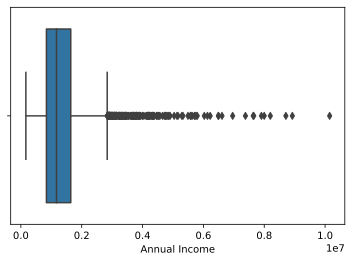

Tax Liens


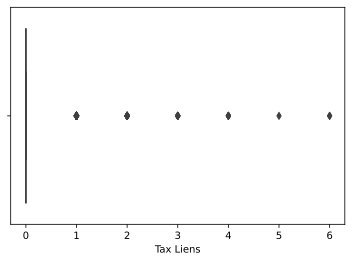

Number of Open Accounts


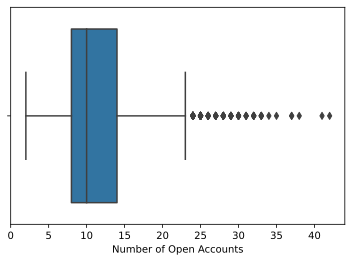

Years of Credit History


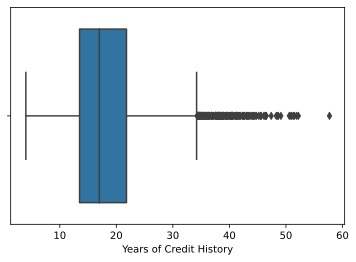

Maximum Open Credit


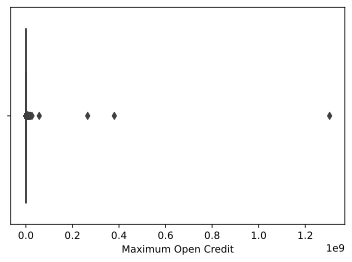

Number of Credit Problems


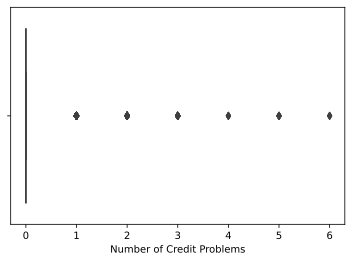

Months since last delinquent


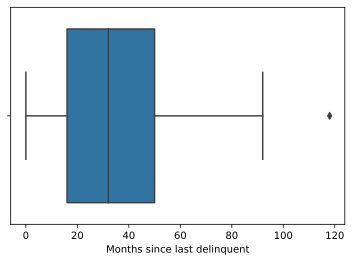

Bankruptcies


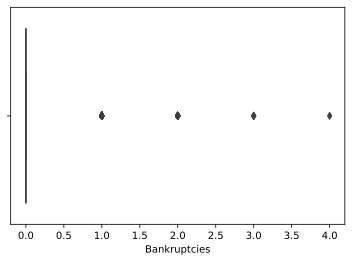

Current Loan Amount


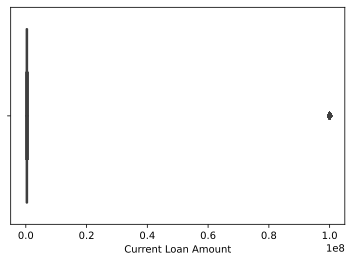

Current Credit Balance


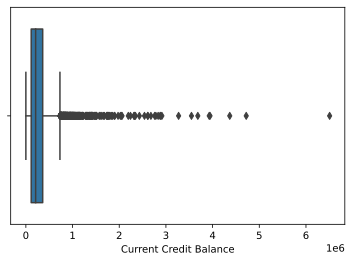

Monthly Debt


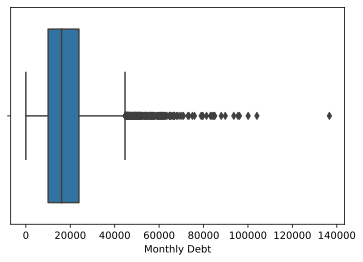

Credit Score


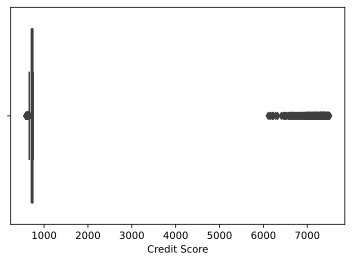

Credit Default


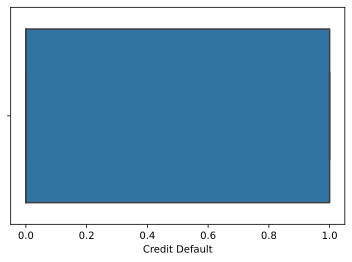

In [10]:
for colname in train.select_dtypes(exclude='object').columns:
    print(colname)
    sns.boxplot(train[colname])
    plt.show()

Признак Credit Score (отсутствует в описании датасета) явным образом делится на два кластера, причем значения различаются кратно. Вероятно, разные единицы измерения.

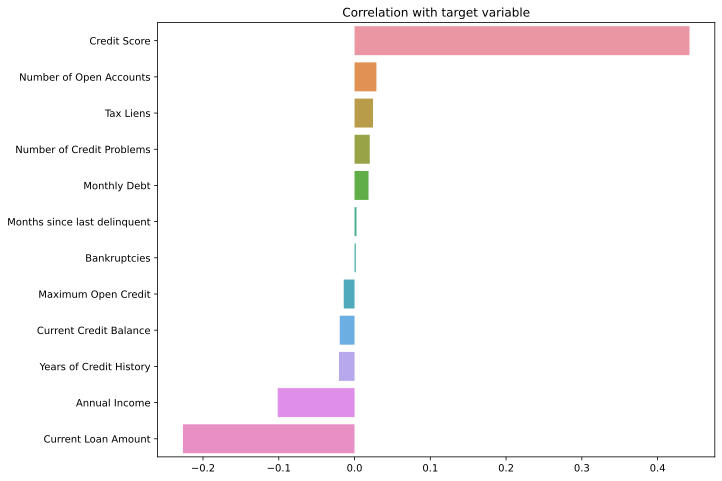

In [11]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = data.columns.drop(TARGET_NAME).tolist()

corr_with_target = data[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

### Обработка выбросов и пропусков

In [12]:
def modify_data(dataframe):
    df = dataframe.copy()

    df.loc[df['Bankruptcies'].isnull(), 'Bankruptcies'] = train['Bankruptcies'].median()
    df.loc[df['Credit Score'] > 1000, ['Credit Score']] /= 10    
    df.loc[df['Credit Score'].isnull(), 'Credit Score'] = df['Credit Score'].median()
    
    df.loc[df['Annual Income'].isnull(), 'Annual Income'] = df['Annual Income'].median()
    df.loc[df['Months since last delinquent'].isnull(), 'Months since last delinquent'] = -1
    
    
    df.loc[df['Term'] == 'Short Term', 'Term'] = '0'
    df.loc[df['Term'] == 'Long Term', 'Term'] = '1'
    df['Term'] = df['Term'].astype("int8")
    
    # Заменяем Purpose, Home Ownership на dummy признаки
    df['Purpose'] = df['Purpose'].astype("category")
    df['Home Ownership'] = df['Home Ownership'].astype("category")
    df = pd.get_dummies(df, columns=['Home Ownership', 'Purpose'])
    
    # Обработка стажа
    
    df['Years in current job'].replace(to_replace=r'[^\d]+', value='', inplace=True, regex=True)
    df.loc[df['Years in current job'].isna() == True, 'Years in current job'] = '-1'
    df['Years in current job'] = df['Years in current job'].astype(int)
    df.loc[df['Years in current job'] == 999, 'Years in current job'] = int(df['Years in current job'].median())
    
    
    return df
    

    
   

In [13]:

train.loc[train['Credit Score'] < 1000, ['Credit Score']].median()

Credit Score    729.0
dtype: float64

In [14]:
# train[train['Bankruptcies'].isnull()].head(5)


In [15]:
# train.loc[train['Annual Income'] > 5*10**6, :].head(5)

В целом, большая зарплата - возможна. Люди из подвыборки выше значительно чаще платят в срок кредит, чем в среднем по выборке, поэтому значение пока не меняю. Но, возможно, стоит установить "потолок" зарплаты, скажем, на 99 процентилях.

In [16]:
median_accounts = train['Number of Open Accounts'].median()
median_accounts

10.0

In [17]:
# train.loc[train['Number of Open Accounts'] > 37, :].head()

Значение в примерно 4 медианных не выглядит как выброс, а люди с большим количеством аккаунтов чаще не платят, чем платят, так что возможно этот признак важен.

In [18]:
# train.loc[train['Years of Credit History'] > 50, :].head()

Данные не выглядят как выброс. Обратил внимание на признак Years in current job - у "пенсионеров" часто NaN, что логично. Нужно учесть при обработке этого признака, возможно, ввести дополнительный признак.

In [19]:
# train.loc[train['Maximum Open Credit'] > 10**7, :].head()

Большие кредиты хорошо возвращаются, так же сумма ограничена максимумом в 99999999. Поэтому оставляю без изменений.

In [20]:
# train.loc[train['Monthly Debt'] > 70000, :].head()

Значения визуально "соответствуют действительности" - либо сумма кредита большая, либо кредит короткий.

In [21]:
# train.loc[train['Credit Score'] > 1000, :].head()

In [22]:
# train.loc[train['Credit Score'] < 1000, :].head()

Явное "расслоение" данных. Одна часть имеет кредитную историю в районе 700, другая - ровно в десять раз больше, около 7000. Есть смысл разделить "выбросы" на десять.

In [23]:
# train.loc[train['Months since last delinquent'].isnull(), :].head()

Множество пропусков Months since last delinquent вполне закономерно, многие клиенты могли не просрачивать платежи вовсе. Поскольку планируется применять бустинговые модели, есть возможность заменить пропуски значением (-1), подмена же усредненными значениями только загрязнит данные.

### Обработка данных

In [24]:
train = modify_data(train)


In [25]:
valid = modify_data(valid)

In [26]:
X_test = modify_data(X_test)

In [27]:
data = modify_data(data)

In [28]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Annual Income,5625.0,1.323311e+06,7.396364e+05,164597.0,931665.0,1171920.0,1505104.0,1.014934e+07
Years in current job,5625.0,5.626489e+00,3.729812e+00,-1.0,2.0,6.0,10.0,1.000000e+01
Tax Liens,5625.0,3.004444e-02,2.646566e-01,0.0,0.0,0.0,0.0,6.000000e+00
Number of Open Accounts,5625.0,1.115200e+01,4.935844e+00,2.0,8.0,10.0,14.0,4.200000e+01
Years of Credit History,5625.0,1.833543e+01,7.084915e+00,4.0,13.5,17.0,21.8,5.770000e+01
Maximum Open Credit,5625.0,1.022467e+06,1.848610e+07,0.0,280170.0,481910.0,793078.0,1.304726e+09
Number of Credit Problems,5625.0,1.660444e-01,4.886541e-01,0.0,0.0,0.0,0.0,6.000000e+00
Months since last delinquent,5625.0,1.528640e+01,2.300167e+01,-1.0,-1.0,-1.0,29.0,1.180000e+02
Bankruptcies,5625.0,1.128889e-01,3.361028e-01,0.0,0.0,0.0,0.0,4.000000e+00
Term,5625.0,2.593778e-01,4.383322e-01,0.0,0.0,0.0,1.0,1.000000e+00


### Визуализация и первичный анализ

In [29]:
features = ['Credit Default', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History',
            'Maximum Open Credit', 'Number of Credit Problems', 'Bankruptcies',
            'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
            'Term', 'Credit Score']

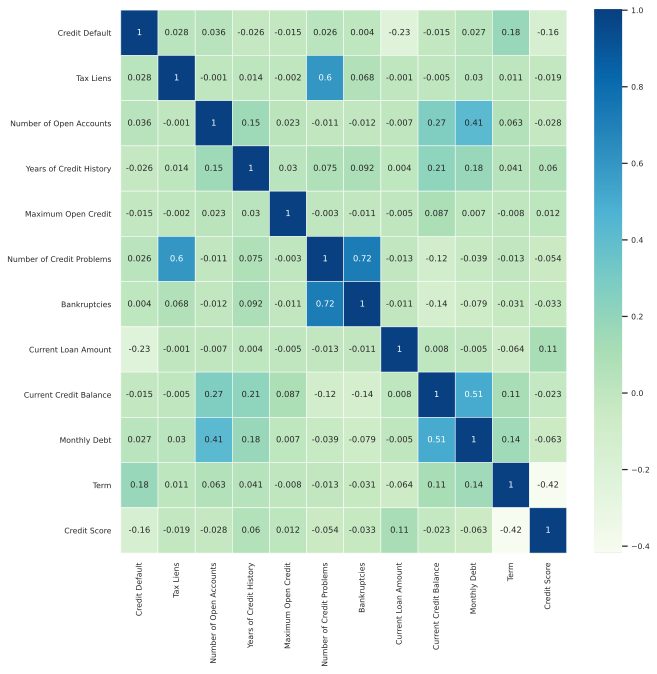

In [30]:
plt.figure(figsize=(10,10))

sns.set(font_scale=0.7)
sns.heatmap(train[features].corr().round(3),annot=True, linewidths=0.5, cmap='GnBu');

In [31]:
def build_combined_graph(feature, target):
    credit_score_with_target_s = train[[feature, target]].sample(2000)
    credit_score_s = credit_score_with_target_s[feature]
    credit_score_target_0 = credit_score_s[credit_score_with_target_s[target] == 0]
    credit_score_target_1 = credit_score_s[credit_score_with_target_s[target] == 1]

    plt.figure(figsize=(10, 5))

    sns.kdeplot(credit_score_target_0, shade=True, label='Target=0', color='g')
    sns.kdeplot(credit_score_target_1, shade=True, label='Target=1', color='r')

    plt.xlabel(feature)
    plt.title(f'{feature} grouped by target variable')
    plt.show()

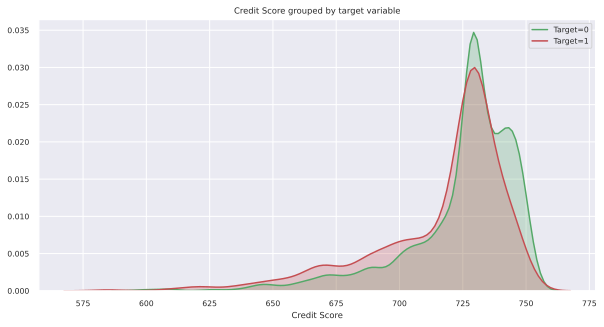

In [32]:
build_combined_graph('Credit Score', 'Credit Default')

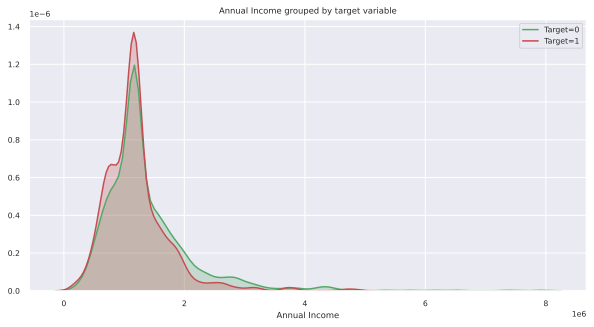

In [33]:
build_combined_graph('Annual Income', 'Credit Default')

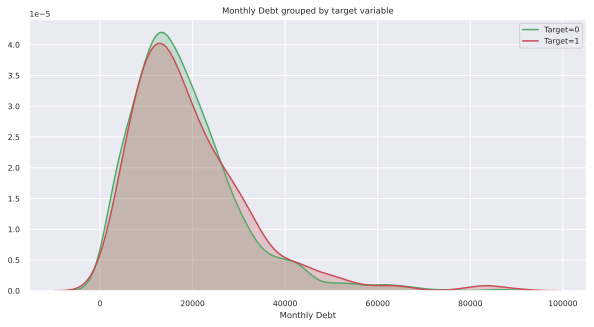

In [34]:
build_combined_graph('Monthly Debt', 'Credit Default')

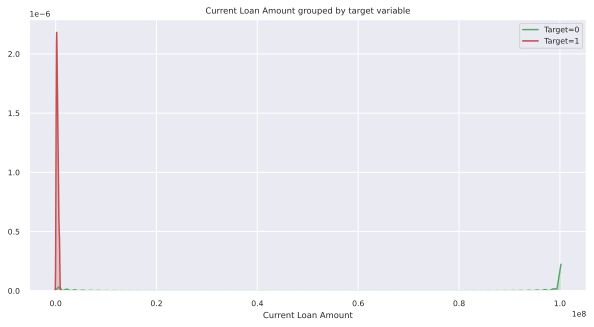

In [35]:
build_combined_graph('Current Loan Amount', 'Credit Default')

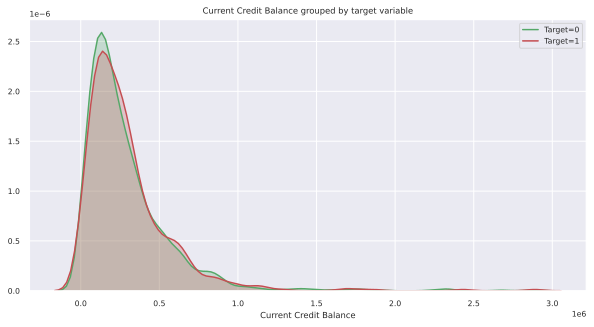

In [36]:
build_combined_graph('Current Credit Balance', 'Credit Default')

Выводы: Между данными переменными и целевой существует функциональная взаимосвязь, более сложная, чем корелляции.Очень часто не возвращаются малые кредиты, для кредитной истории и годового дохода есть явно выраженные "пороговые значения". Однако, поскольку алгоритм будет на основе классификаторов, смысла вводить дополнительные признаки на основе этих данных нет.

### Балансировка и нормализация данных

In [37]:
# значимые признаки:
SELECTED_FEATURE_NAMES = [
    'Credit Score',
    'Current Loan Amount', 
    'Annual Income', 
    'Term', 
    'Home Ownership_Rent', 
    'Home Ownership_Home Mortgage',
    'Purpose_small business',
    'Number of Open Accounts',
    'Purpose_renewable energy',
    'Tax Liens',
    'Number of Credit Problems',
    'Monthly Debt',
    'Years of Credit History',
    'Current Credit Balance',
    'Purpose_debt consolidation',
    'Purpose_educational expenses'
]

# признаки для нормализации:

NUM_FEATURE_NAMES = [
    'Annual Income',
    'Years in current job',
    'Tax Liens', 
    'Number of Open Accounts',
    'Years of Credit History',
    'Maximum Open Credit',
    'Number of Credit Problems',
    'Months since last delinquent',
    'Bankruptcies',
    'Term',
    'Current Loan Amount',
    'Current Credit Balance',
    'Monthly Debt',
    'Credit Score'
]

In [38]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [39]:
scaler = StandardScaler()

df_norm = data.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_test_norm = X_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.transform(df_test_norm[NUM_FEATURE_NAMES])


In [40]:
df_norm.head(3)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_renewable energy,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-1.114304,-1.773111,-0.110953,-0.026674,1.133645,-0.016174,1.664779,-0.706511,2.545732,-0.591517,...,0,0,0,0,0,0,0,0,0,0
1,-0.396190,1.175343,-0.110953,0.788223,-0.428528,0.014763,-0.340979,-0.706511,-0.337099,1.690569,...,0,0,0,0,0,0,0,0,0,0
2,-0.758385,0.639261,-0.110953,-0.026674,2.369181,0.014807,-0.340979,-0.706511,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0


In [41]:
df_test_norm.head(3)

,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Term,...,Purpose_educational expenses,Purpose_home improvements,Purpose_major purchase,Purpose_medical bills,Purpose_moving,Purpose_other,Purpose_small business,Purpose_take a trip,Purpose_vacation,Purpose_wedding
0,-0.194013,-0.432905,-0.110953,-0.434123,-0.826171,-0.045191,-0.340979,2.376403,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0
1,-1.445013,-1.237029,-0.110953,-1.045295,2.042545,-0.055488,-0.340979,-0.315719,-0.337099,-0.591517,...,1,0,0,0,0,0,0,0,0,0
2,-0.228287,-0.700946,-0.110953,-0.230398,-0.655753,-0.046212,-0.340979,-0.706511,-0.337099,-0.591517,...,0,0,0,0,0,0,0,0,0,0


In [42]:
# При преобразовании X_test получил ошибку "['Purpose_renewable energy'] not in index"
# Очевидно, в данных просто не было такого варианта. Добавлю соответствующий столбец, заполнив нулями.

df_test_norm['Purpose_renewable energy'] = 0 

In [43]:
df_balanced = balance_df_by_target(df_norm, TARGET_NAME)
df_balanced[TARGET_NAME].value_counts()

0    5387
1    4226
Name: Credit Default, dtype: int64

### Выбираем и бучаем модель

In [44]:
X = df_balanced[SELECTED_FEATURE_NAMES]
y = df_balanced[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Тест бустинговых алгоритмов

In [45]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))


### XGB

In [46]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train[SELECTED_FEATURE_NAMES])
y_test_pred = model_xgb.predict(X_test[SELECTED_FEATURE_NAMES])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

/home/pavel/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.94      0.95      0.95      3776
           1       0.94      0.93      0.93      2953

    accuracy                           0.94      6729
   macro avg       0.94      0.94      0.94      6729
weighted avg       0.94      0.94      0.94      6729

TEST

              precision    recall  f1-score   support

           0       0.78      0.73      0.75      1611
           1       0.68      0.74      0.71      1273

    accuracy                           0.73      2884
   macro avg       0.73      0.73      0.73      2884
weighted avg       0.74      0.73      0.73      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0          

### LightGBM

In [47]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train[SELECTED_FEATURE_NAMES])
y_test_pred = model_lgbm.predict(X_test[SELECTED_FEATURE_NAMES])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.87      0.91      0.89      3776
           1       0.87      0.83      0.85      2953

    accuracy                           0.87      6729
   macro avg       0.87      0.87      0.87      6729
weighted avg       0.87      0.87      0.87      6729

TEST

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1611
           1       0.67      0.67      0.67      1273

    accuracy                           0.71      2884
   macro avg       0.70      0.70      0.70      2884
weighted avg       0.71      0.71      0.71      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1183  428
1                416  857


### CatBoost

In [48]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train[SELECTED_FEATURE_NAMES])
y_test_pred = model_catb.predict(X_test[SELECTED_FEATURE_NAMES])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      3776
           1       0.83      0.80      0.81      2953

    accuracy                           0.84      6729
   macro avg       0.84      0.84      0.84      6729
weighted avg       0.84      0.84      0.84      6729

TEST

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1611
           1       0.67      0.66      0.66      1273

    accuracy                           0.71      2884
   macro avg       0.70      0.70      0.70      2884
weighted avg       0.71      0.71      0.71      2884

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1205  406
1                439  834


При тестах "по дефолту" метрика F1 на валидационной выборке оказалась равной для LightGBM и CatBoost, однако XGB показала лучший результат.

Поскольку есть достаточно времени для тестов, обучу модели с разными параметрами, и выберу лучшую из уже настроенных.



In [ ]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 2.5], silent=True, random_state=21)
model_lgbm = lgbm.LGBMClassifier(class_weights=[1, 3], silent=True, random_state=21)
model_xgb = xgb.XGBClassifier(silent=True, random_state=21)



Перебор гиперпараметров

In [50]:
# params = {'n_estimators':[50, 100, 200, 500, 700, 1000],
#           'max_depth':[3, 5, 7],
#          'class_weights':[[1, 1], [1, 2], [1, 2.5], [1, 3]],
#          'l2_leaf_reg':[1, 2 , 5, 10, 20,],}

params = {'n_estimators':[50, 100, 150, 200, 250, 300, 400, 500,],
          'max_depth':[3, 4, 5, 7, 10, 15],
         'l2_leaf_reg':[1, 2 , 5, 7, 10],}

In [51]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)


In [52]:
# %%time

# rs = RandomizedSearchCV(model_catb, params, scoring='f1', n_iter=10, cv=cv, n_jobs=2)
# rs.fit(X, y)

/home/pavel/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 5min 51s, sys: 8.45 s, total: 6min
Wall time: 15min 23s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x7fdc12bd18b0>,
                   n_jobs=2,
                   param_distributions={'l2_leaf_reg': [1, 2, 5, 7, 10],
                                        'max_depth': [3, 4, 5, 7, 10, 15],
                                        'n_estimators': [50, 100, 150, 200, 250,
                                                         300, 400, 500]},
                   scoring='f1')

In [53]:
# rs.best_params_

{'n_estimators': 400, 'max_depth': 15, 'l2_leaf_reg': 5}

In [54]:
# rs.best_score_

0.7702570440000757

model_catb

{'n_estimators': 400, 'max_depth': 15, 'l2_leaf_reg': 5}

0.7702570440000757 

model_xgb
 
 {'n_estimators': 200, 'max_depth': 10, 'l2_leaf_reg': 2}
 
 0.7655167099922843
 
При подборе гиперпараметров model_catb показала наилучшие результаты, ее и применим для финального предсказания.

### Проверяем модель с лучшими параметрами

In [55]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=400, 
                                      max_depth=15,
                                      l2_leaf_reg=5,
                                      silent=True, 
                                      random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Измеряем качество обучения
get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3776
           1       1.00      1.00      1.00      2953

    accuracy                           1.00      6729
   macro avg       1.00      1.00      1.00      6729
weighted avg       1.00      1.00      1.00      6729

TEST

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      1611
           1       0.76      0.82      0.79      1273

    accuracy                           0.81      2884
   macro avg       0.80      0.81      0.80      2884
weighted avg       0.81      0.81      0.81      2884

CONFUSION MATRIX

col_0              0     1
Credit Default            
0               1273   338
1                224  1049
CPU times: user 6min 26s, sys: 10.6 s, total: 6min 37s
Wall time: 2min 17s


### Обучаем модель на всех данных

In [56]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=400, 
                                      max_depth=15,
                                      l2_leaf_reg=5,
                                      silent=True, 
                                      random_state=21)
final_model.fit(X, y)

y_train_pred = final_model.predict(X_train)


CPU times: user 6min 22s, sys: 8.62 s, total: 6min 31s
Wall time: 2min 13s


### Сверяем формат данных в тренировочном и финальном датасете.

In [57]:
X_final = df_test_norm[SELECTED_FEATURE_NAMES]

In [58]:
X_final.head(5)

,Credit Score,Current Loan Amount,Annual Income,Term,Home Ownership_Rent,Home Ownership_Home Mortgage,Purpose_small business,Number of Open Accounts,Purpose_renewable energy,Tax Liens,Number of Credit Problems,Monthly Debt,Years of Credit History,Current Credit Balance,Purpose_debt consolidation,Purpose_educational expenses
0,0.201333,-0.366831,-0.194013,-0.591517,1,0,0,-0.434123,0,-0.110953,-0.340979,-0.964404,-0.826171,-0.578660,1,0
1,-0.912175,-0.369468,-1.445013,-0.591517,1,0,0,-1.045295,0,-0.110953,-0.340979,-1.341313,2.042545,-0.767016,0,1
2,0.161565,-0.365650,-0.228287,-0.591517,0,1,0,-0.230398,0,-0.110953,-0.340979,0.034760,-0.655753,-0.450977,1,0
3,0.678550,-0.365111,-0.138724,-0.591517,0,1,0,0.991947,0,-0.110953,-0.340979,0.775161,-0.187101,-0.241102,1,0
4,-0.633798,-0.347561,1.342223,1.690569,0,1,0,-0.026674,0,-0.110953,-0.340979,2.036777,0.750203,0.426483,1,0


In [59]:
X.head(5)

,Credit Score,Current Loan Amount,Annual Income,Term,Home Ownership_Rent,Home Ownership_Home Mortgage,Purpose_small business,Number of Open Accounts,Purpose_renewable energy,Tax Liens,Number of Credit Problems,Monthly Debt,Years of Credit History,Current Credit Balance,Purpose_debt consolidation,Purpose_educational expenses
371,0.996695,-0.367515,-0.070955,-0.591517,0,1,0,-0.026674,0,-0.110953,-0.340979,-1.024777,0.040124,-0.024352,1,0
3206,-0.236117,2.760520,-1.100594,-0.591517,0,0,0,0.584498,0,-0.110953,-0.340979,-0.837119,0.054326,-0.084487,1,0
5771,0.797855,-0.370686,-0.726874,-0.591517,1,0,0,-0.637847,0,-0.110953,-0.340979,-0.631014,-1.081800,-0.536697,0,0
8291,0.002492,-0.367812,0.119546,-0.591517,0,1,0,-0.026674,0,-0.110953,-0.340979,0.284551,0.949024,-0.405726,1,0
6769,1.076232,2.760520,0.529875,-0.591517,0,1,0,0.380774,0,-0.110953,1.664779,-0.160612,0.593985,-0.778852,0,0


### Делаем прогноз и сохраняем данные

In [61]:
y_final = final_model.predict(X_final)

In [62]:
y_final

array([0, 1, 0, ..., 0, 0, 1])

In [66]:
X_final['Credit Default'] = y_final

In [67]:
X_final.to_csv('result.csv')